#IMPORTING THE LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
import math
import warnings
warnings.filterwarnings("ignore")

#DATA PREPROCESSING

In [2]:
df=pd.read_csv('dataset.csv')

In [3]:
df=df.drop('Field',axis=1)

In [4]:
print(df.head())

         Date  FIBBG000B9XRY4
0  2023-01-03         124.375
1  2023-01-04         125.658
2  2023-01-05         124.325
3  2023-01-06         128.900
4  2023-01-09         129.427


In [5]:
df.columns=['Date','Close']

#DATA VISUALIZATION

In [9]:
df.describe()


,Close
count,250.000000
mean,172.121068
std,17.504105
min,124.325000
25%,161.457250
50%,175.244000
75%,187.177750
max,198.110000


#MOVING AVERAGE PLOT

In [12]:
df1=df.copy()
print(df.head())
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True)

window_size = 3
df1['SMA'] = df1['Close'].rolling(window=window_size).mean()

# Create an interactive plot using Plotly Express for closing prices
fig = px.line(df1, x=df1.index, y=['Close'], title='Stock Price with Moving Average')

# Add a scatter trace for the SMA
fig.add_trace(go.Scatter(x=df1.index, y=df1['SMA'], mode='lines', name=f'{window_size}-Day SMA',
                         line=dict(dash='dash', color='orange')))

# Customize the layout
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Stock Price with Moving Average (Plotly)',
    template='plotly_dark',  # Change the template to a dark theme
)

# Add data points for actual closing prices with hover information
fig.update_traces(marker=dict(size=8, line=dict(width=2, color='white')), selector=dict(mode='markers'))
fig.show()

         Date    Close
0  2023-01-03  124.375
1  2023-01-04  125.658
2  2023-01-05  124.325
3  2023-01-06  128.900
4  2023-01-09  129.427


#LINE PLOT FOR CHECKING THE TREND OF STOCK


In [10]:
df2=df.copy()
df2['Date'] = pd.to_datetime(df2['Date'])

fig = px.line(df2, x='Date', y='Close', markers=True, title='Closing Prices Over Time')

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Closing Price',
    title='Interactive Line Chart with Effects',
    template='plotly_dark',  # Change the template to a dark theme
    hovermode='x',  # Display hover information on the x-axis
    showlegend=True,  # Show legend
)

fig.update_traces(marker=dict(size=8, line=dict(width=2, color='DarkSlateGray')))
fig.show()

##DECOMPOSITION

1.   TREND
2.   SEASONAL
3.   RESIDUAL
4.   OBSERVED



In [14]:
df3=df.copy()

result = seasonal_decompose(df3['Close'], model='additive', period=30)  # Adjust the period as needed

# Create a DataFrame with the components
components_df = pd.DataFrame({
    'Trend': result.trend,
    'Seasonal': result.seasonal,
    'Residual': result.resid,
    'Observed': df3['Close'],
})

# Plot the components using Plotly
fig = go.Figure()

for column in components_df.columns:
    fig.add_trace(go.Scatter(x=components_df.index, y=components_df[column], mode='lines', name=column))

# Customize the layout
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Value',
    title='Time Series Decomposition',
    template='plotly_dark',  # Change the template to a dark theme
)

# Show the plot
fig.show()

ARIMA MODEL


In [ ]:
#!pip install pmdarima


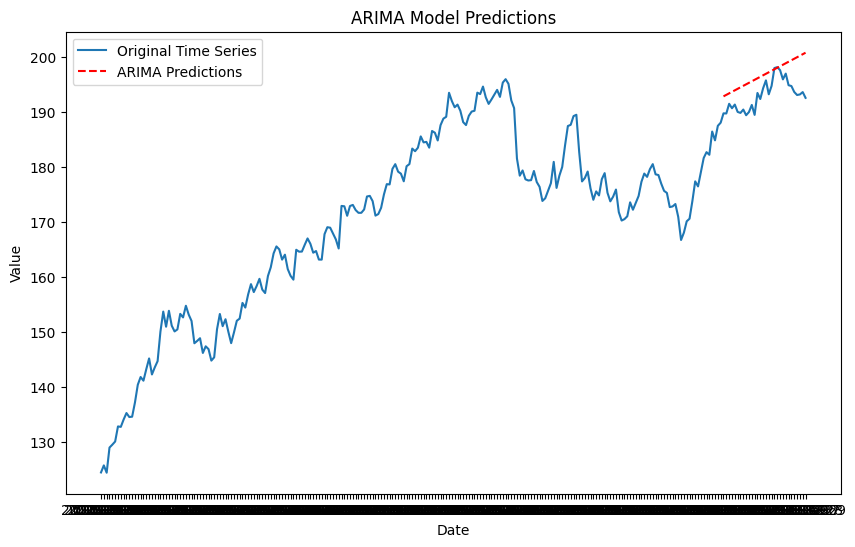

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Assuming df is your DataFrame with the 'Date' and 'Value' columns
df2 = df.copy()

# Fit ARIMA model using pmdarima
arima_model = auto_arima(df['Close'], seasonal=False, suppress_warnings=True)
arima_results = arima_model.fit(df['Close'])

# Predict values using the fitted model
predicted_values = arima_results.predict(n_periods=30)

# Plot the original and predicted time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Original Time Series')
plt.plot(df.index[-30:], predicted_values, label='ARIMA Predictions', color='red', linestyle='--')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


XGBOOST MODEL FORECASTING


In [66]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import plotly.express as px

df2 = df.copy()
lag_order = 3

for i in range(1, lag_order + 1):
    df2[f'Value_Lag_{i}'] = df2['Close'].shift(i)

df2 = df2.dropna()
df2 = df2.reset_index()
train_size = int(len(df2) * 0.8)
train, test = df2[:train_size], df2[train_size:]

X_train, y_train = train.drop(['Date', 'Close'], axis=1), train['Close']
X_test, y_test = test.drop(['Date', 'Close'], axis=1), test['Close']

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')

# Create a Plotly figure
fig = px.line(test, x='Date', y=['Close', pd.Series(y_pred, index=test.index)],
              labels={'value': 'Value', 'variable': 'Series'},
              title='XGBoost Time Series Forecasting')

# Add markers for actual and predicted values
fig.add_trace(px.scatter(test, x='Date', y='Close').data[0])
fig.add_trace(px.scatter(test, x='Date', y=pd.Series(y_pred, index=test.index)).data[0])

# Show the figure
fig.show()


Mean Squared Error on Test Set: 7.810980385339077


#ADFULLER TEST FOR CHECKING STATIONARY

In [15]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df4=df.copy()
df4['Date'] = pd.to_datetime(df4['Date'])
df4.set_index('Date', inplace=True)
result = adfuller(df4['Close'])
test_statistic, p_value, _, _, _, _ = result
print(f'Test Statistic: {test_statistic}')
print(f'P-value: {p_value}')

if p_value <= 0.05:
    print("The time series is likely stationary (reject the null hypothesis)")
else:
    print("The time series is likely non-stationary (fail to reject the null hypothesis)")


Test Statistic: -2.5861110326138066
P-value: 0.09590194595133555
The time series is likely non-stationary (fail to reject the null hypothesis)


#TAKING LOG DIFFERENCIATION

In [27]:
import pandas as pd
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller

df5 = df.copy()

fig_original = go.Figure()
fig_original.add_trace(go.Scatter(x=df.index, y=df5['Close'], mode='lines', name='Original Time Series'))
fig_original.update_layout(title='Original Time Series',xaxis_title='Date',yaxis_title='Close Price',template='plotly_dark')

result_original = adfuller(df5['Close'])
print("ADF Test on Original Time Series:")
print(f'Test Statistic: {result_original[0]}')
print(f'P-value: {result_original[1]}')
df5['Log_Close'] = np.log(df5['Close'])
fig_diff = go.Figure()
fig_diff.add_trace(go.Scatter(x=df.index, y=df5['Log_Close'], mode='lines', name='Differenced Time Series'))
fig_diff.update_layout(title='Differenced Time Series (Stationary)',xaxis_title='Date',yaxis_title='Differenced Close Price',template='plotly_dark')

result_diff = adfuller(df5['Log_Close'])
print("\nADF Test on Differenced Time Series:")
print(f'Test Statistic: {result_diff[0]}')
print(f'P-value: {result_diff[1]}')
fig_original.show()
fig_diff.show()


ADF Test on Original Time Series:
Test Statistic: -2.5861110326138066
P-value: 0.09590194595133555

ADF Test on Differenced Time Series:
Test Statistic: -3.080806078633327
P-value: 0.028006619477011756


#MODEL


In [45]:
df1=df.copy()
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True)
returns=df1.pct_change()
df1['returns']=returns['Close']
print(df.head())

         Date    Close
0  2023-01-03  124.375
1  2023-01-04  125.658
2  2023-01-05  124.325
3  2023-01-06  128.900
4  2023-01-09  129.427


In [46]:
print(df1.head())

              Close   returns
Date                         
2023-01-03  124.375       NaN
2023-01-04  125.658  0.010316
2023-01-05  124.325 -0.010608
2023-01-06  128.900  0.036799
2023-01-09  129.427  0.004088


In [47]:
def state_classification():
  s=[]
  s1=[]
  for i in df1['returns'].values:
      if i>=0.01:
          s.append(1)
          s1.append('bull')
      elif i>-0.01:
          s.append(0)
          s1.append('flat')
      else:
          s.append(-1)
          s1.append('bear')
  return s,s1



def calculate_transition_matrix(states):
    transition_matrix = np.zeros((3, 3))

    for i in range(1, len(states)):
        current_state = int(states[i - 1]) + 1
        next_state = int(states[i]) + 1
        transition_matrix[current_state, next_state] += 1

    # Check for division by zero
    non_zero_rows = (transition_matrix.sum(axis=1) != 0)
    transition_matrix[non_zero_rows] /= transition_matrix[non_zero_rows].sum(axis=1, keepdims=True)

    return transition_matrix

def simulate_trading(prices):
    states=df1['state'].values
    portfolio_value = 0
    optimal_buy_indices = []

    for i in range(1,len(prices)-1):
        current_state = int(states[i - 1])
        next_state = int(states[i])

        if next_state == 1 and current_state == 0:
            portfolio_value += 1
            optimal_buy_indices.append(i)

        elif next_state == -1 and current_state == 0:
            portfolio_value -= 1
            optimal_buy_indices.append(i)

    transition_matrix = calculate_transition_matrix(states)

    return portfolio_value, optimal_buy_indices, transition_matrix

s,s1=state_classification()
df1['state']=s
df1['category']=s1
final_portfolio_value, optimal_buy_indices, transition_matrix = simulate_trading(df['Close'].values)
print("Final Portfolio Value:", final_portfolio_value)
print("Optimal Buy Indices:", optimal_buy_indices)
print("\nTransition Matrix:")
print(pd.DataFrame(transition_matrix, index=['Bear', 'Flat', 'Bull'], columns=['Bear', 'Flat', 'Bull']))

Final Portfolio Value: 17
Optimal Buy Indices: [6, 8, 12, 16, 21, 28, 30, 33, 36, 39, 41, 45, 50, 52, 57, 59, 61, 64, 66, 69, 79, 85, 88, 94, 97, 100, 103, 108, 110, 113, 117, 120, 123, 128, 133, 136, 142, 145, 147, 154, 156, 160, 164, 169, 173, 177, 179, 183, 187, 191, 196, 201, 204, 207, 209, 212, 216, 218, 232, 234, 236, 238, 243]

Transition Matrix:
          Bear      Flat      Bull
Bear  0.138889  0.722222  0.138889
Flat  0.146497  0.598726  0.254777
Bull  0.125000  0.678571  0.196429


In [48]:
final_Dates=df1.iloc[optimal_buy_indices,0]
print(final_Dates)

Date
2023-01-11    132.748
2023-01-13    134.011
2023-01-20    137.104
2023-01-26    143.160
2023-02-02    149.982
               ...   
2023-12-05    193.420
2023-12-07    194.270
2023-12-11    193.180
2023-12-13    197.960
2023-12-20    194.830
Name: Close, Length: 63, dtype: float64


Enter the number of days to forecast: 14
Forecasted values for the next 14 days:
250    192.425871
251    192.477162
252    192.451898
253    192.464342
254    192.458212
255    192.461232
256    192.459744
257    192.460477
258    192.460116
259    192.460294
260    192.460206
261    192.460249
262    192.460228
263    192.460239
Name: predicted_mean, dtype: float64


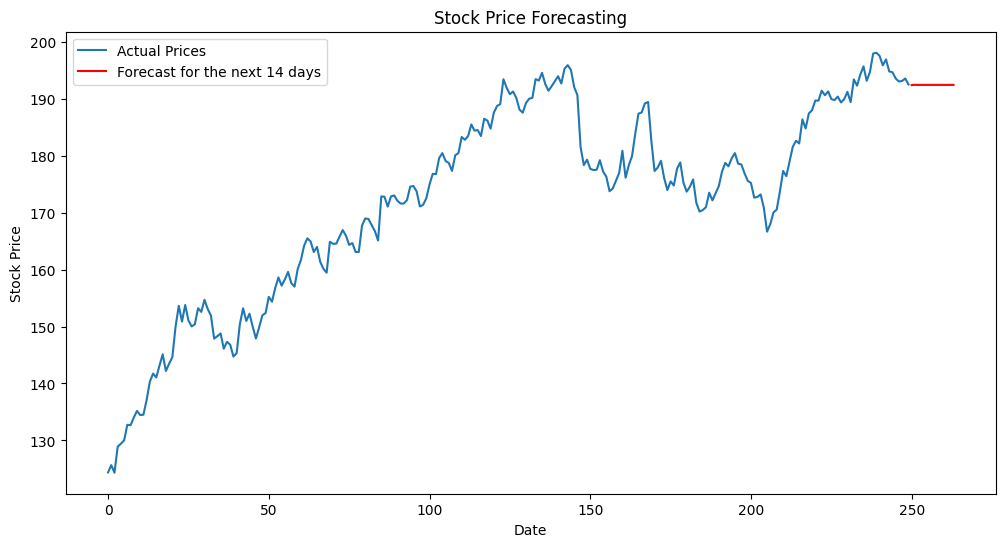

In [22]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


time_series = df['Close']

# Fit an ARIMA model
order = (1, 1, 1)
model = ARIMA(time_series, order=order)
fit_model = model.fit()


n = int(input("Enter the number of days to forecast: "))
forecast = fit_model.get_forecast(steps=n)
forecast_values = forecast.predicted_mean
print(f"Forecasted values for the next {n} days:")
print(forecast_values)
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Actual Prices')
plt.plot(forecast.predicted_mean, color='red', label=f'Forecast for the next {n} days')
plt.title('Stock Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
